## Analysis of voxelwise fwrf gabor models, 2014 imagery.rf data



In [21]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import leave_k_out_training, split_em_up
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from math import atan2, degrees
from IPython.display import Image as ipyImage

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0. load the models

In [23]:
##must first redefine the activation function to the namespace or pickle annoyingly wont work
def log_act_func(x):
    return np.log(1+np.sqrt(x))


In [24]:
subject = 'TN'
state_list = ['pcp', 'img'] #['cue_pcp', 'cue_img', 'img', 'pcp']
saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'
mst={}
val_cc = {} 
for ii,state in enumerate(state_list):
    saving_file = 'model_space_'+'fwrf_gabor_robust_'+state+'_'+subject+'.p'
    mst[state]=pickle.load(open( join(saving_place, saving_file), "r"))

    val_cc[state] = mst[state].val_cc
    val_cc[state] = mst[state].val_cc

## 1. validation scores

#### prediction accuracy histograms

number of voxels with cc > 0.250000, pcp: 10193
number of voxels with cc > 0.250000, img: 2998


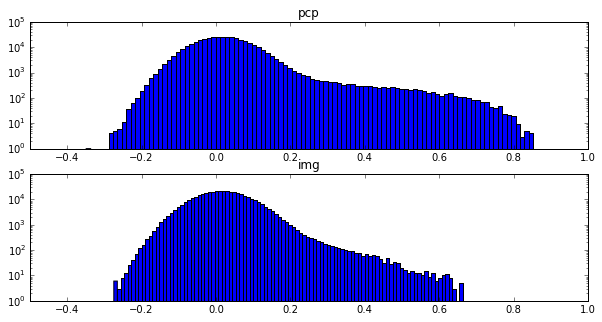

In [25]:
nvox = -1
count_thresh = .25
plt.figure(figsize = (10,5))
for ii,state in enumerate(state_list):#, 'img']):
    plt.subplot(len(state_list),1,ii+1)
    _=plt.hist(val_cc[state][:nvox],100)
    plt.yscale('log')
    plt.ylim([10**0, 10**5])
    plt.xlim([-.5, 1.])
    plt.title(state)
    print 'number of voxels with cc > %f, %s: %d' %(count_thresh,state,np.sum(map(lambda x: x > count_thresh, val_cc[state][:nvox])))

#### prediction accuracy head-to-head

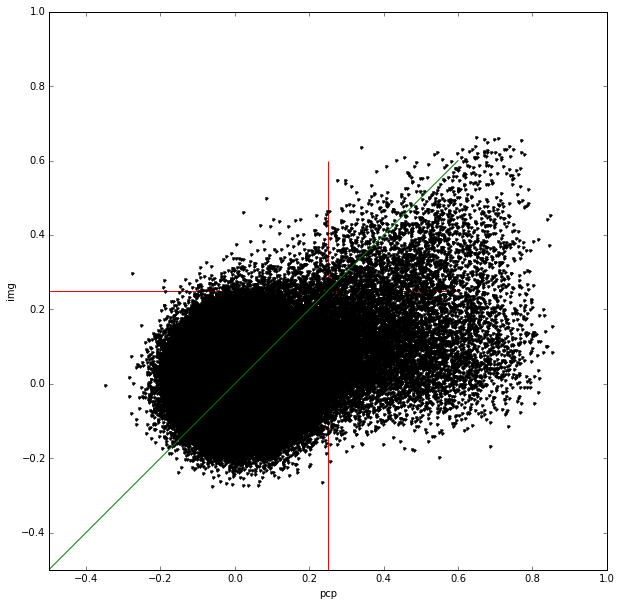

In [26]:
ystate='img'
xstate = 'pcp'
if (xstate in state_list) & (ystate in state_list):
    plt.figure(figsize=(10,10))
    rng = np.linspace(-.6, .6, num=50)
    plt.plot(val_cc[xstate][:nvox], val_cc[ystate][:nvox], 'k.');
    plt.hlines(count_thresh, rng[0], rng[-1], colors='r')
    plt.vlines(count_thresh, rng[0], rng[-1], colors='r')
    plt.plot(rng, rng, 'g')
    
    
    plt.ylabel(ystate)
    plt.xlabel(xstate)
    
    plt.axes().set_aspect(1)
    plt.xlim([-.5, 1])
    plt.ylim([-.5, 1])

In [27]:
skip = 1000
for ii,state in enumerate(state_list):
    print '--%s' %(state)
    for k in mst[state].params.keys():
        beh = mst[state].params[k]['beh']
        print np.mean(beh[-1,:])

--pcp
521488.977999
540960.851068
499874.622828
515752.503107
589423.090497
543415.355783
569057.762929
532589.999082
547201.099666
443671.326867
--img
511087.94201
466502.179783
442106.694815
371625.113377
500667.456442
448621.2372
471597.285547
534892.967022
473046.976077
450374.941046


#### prediction accuracy volumes
to do this, most convenient to load up the original data. doesn't take long.

In [28]:
saving_spot = '/media/tnaselar/Data/scratch/'

beta_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/after_fnirt/betas/'#'/media/tnaselar/Data/imagery_rf.2014/betas/'
file_exp = '%s_all_runs_BETAs_canonicalHRF.mat'


stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/condit_names/%s_condit_names.mat' %(subject)

mask_path = '/musc.repo/Data/jesse/imagery_RF/glmd_new_preproc_undistort_slicetime/brain_masks/%s_mean_func_brain_mask.nii.gz' %(subject)


print '==============+++++++++========SUBJECT: %s' %(subject)
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc)
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

==============+++++++++========SUBJECT: TN


In [29]:
def view_vol_data(data_object, data_vol,save_to = None):
    cur = data_object.mask.ravel(order=data_object.order).copy().astype('float32')
    cur[cur > 0] = data_vol
    view_vol = cur.reshape(data_object.shape,order=data_object.order)
    if save_to:
        nib.save(nib.Nifti1Image(view_vol,affine=np.eye(4)),save_to)
    else:
        return view_vol

In [30]:
for state in state_list:
    view_vol_data(fMRI,val_cc[state], save_to = '/media/tnaselar/Data/scratch/val_cc_'+state+'_gabor_'+subject )

In [ ]:
count_thresh = 0.01
val_rat = np.zeros(len(val_cc['img']))
good_vox = np.where(np.array(map(lambda x: x > count_thresh, val_cc['img'])) & np.array(map(lambda x: x > count_thresh, val_cc['pcp'])))[0]

val_rat[good_vox]= (val_cc['img'][good_vox]/val_cc['pcp'][good_vox])
for state in state_list:
    view_vol_data(fMRI,val_rat, save_to = '/media/tnaselar/Data/scratch/val_ratio'+'_gabor_'+subject )

In [ ]:
print len(good_vox)
_=plt.hist(val_rat[good_vox], 100, log=True)

#### rf locations

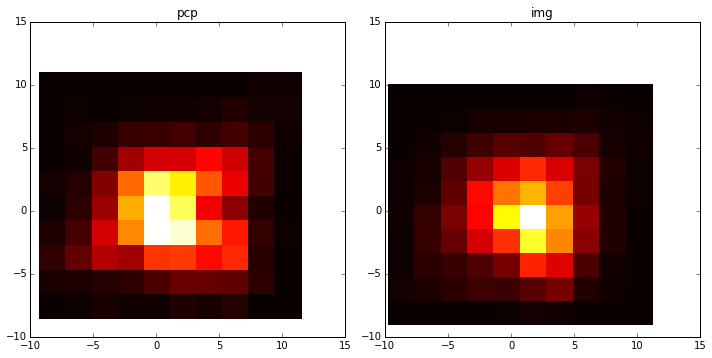

In [31]:
count_thresh = .2
fig = plt.figure(figsize=(10,10))
for ii,state in enumerate(state_list):
    n_resamples = len(mst[state].params)
    dx = np.where(map(lambda x: x > count_thresh, val_cc['img']))[0]
    xd = np.zeros(len(dx))
    yd = np.zeros(len(dx))
    for n in range(n_resamples):
        
        frf = mst[state].params[n]['frf'][dx]
        ax=plt.subplot(1,len(state_list),ii+1)
        plt.title(state)
        xd += mst[state].receptive_fields.rf_table.loc[frf, 'x_deg'].values
        yd += mst[state].receptive_fields.rf_table.loc[frf, 'y_deg'].values
    xd /= n_resamples
    yd /= n_resamples
    nums,xedges,yedges = np.histogram2d(xd,yd)
    ax.set_aspect(1)
#     plt.imshow(np.sum(mst[state].receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')
    plt.pcolor(xedges, yedges, nums,cmap='hot')
#     plt.colorbar(ax=ax)
plt.tight_layout()    

#### rf size vs. location

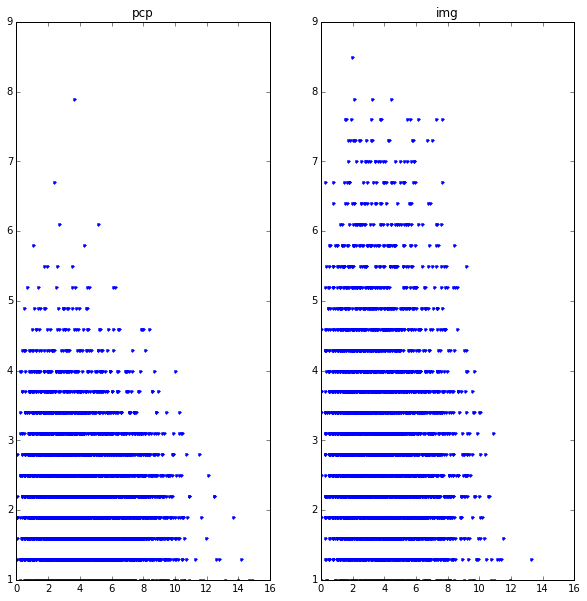

In [57]:
count_thresh = 0.21
fig = plt.figure(figsize=(10,10))
rfsize = {}
for ii,state in enumerate(state_list):
    n_resamples = len(mst[state].params)
    dx = np.where(map(lambda x: x > count_thresh, val_cc['img']))[0]
    xd = np.zeros(len(dx))
    yd = np.zeros(len(dx))
    rfsize[state] = np.zeros(len(dx))
    for n in range(n_resamples):
        
        frf = mst[state].params[n]['frf'][dx]
        xd += mst[state].receptive_fields.rf_table.loc[frf, 'x_deg'].values
        yd += mst[state].receptive_fields.rf_table.loc[frf, 'y_deg'].values
        rfsize[state] += mst[state].receptive_fields.rf_table.loc[frf, 'deg_per_radius'].values
    xd /= n_resamples
    yd /= n_resamples
    rfsize[state] /= n_resamples
    ecc = np.sqrt(xd**2 + yd**2)
#     nums,xedges,yedges = np.histogram2d(ecc,rfsize[state])
    ax=plt.subplot(1,2,ii+1)
#     plt.title(state)
#     plt.pcolor(xedges, yedges, nums,cmap='hot')
#     plt.hist(rfsize[state],20,normed=True)
#     plt.xlim([1,10])
#     plt.ylim([0, .6])
    plt.plot(ecc, rfsize[state], '.')
    plt.ylim([1,9])
    plt.xlim([0,16])
    plt.title(state)
    

In [ ]:
mst[state].receptive_fields.rf_table.loc[frf, 'x_deg'].values

1.3


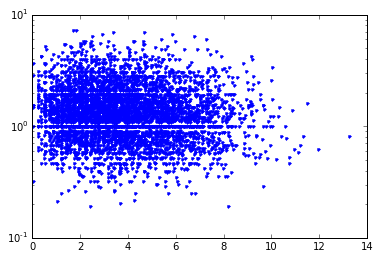

In [33]:
plt.plot(ecc,rfsize['img']/rfsize['pcp'],'.')    
# plt.ylim([0, 9])
plt.yscale('log')
# plt.xlim([0, 10])

# plt.hist(rfsize['img']/rfsize['pcp'],15, log=True)
# plt.hist(rfsize['pcp']/rfsize['img'],15, log=True,hold=True)
# plt.scatter(rfsize['pcp'], rfsize['img'])
# plt.xlim([0,10])
# plt.ylim([0, 10])
# plt.axes().set_aspect(1)
print np.median(rfsize['img']/rfsize['pcp'])

#### rf location vs. prediction accuracy

mean ecc: 3.876875
mean ecc: 3.898195


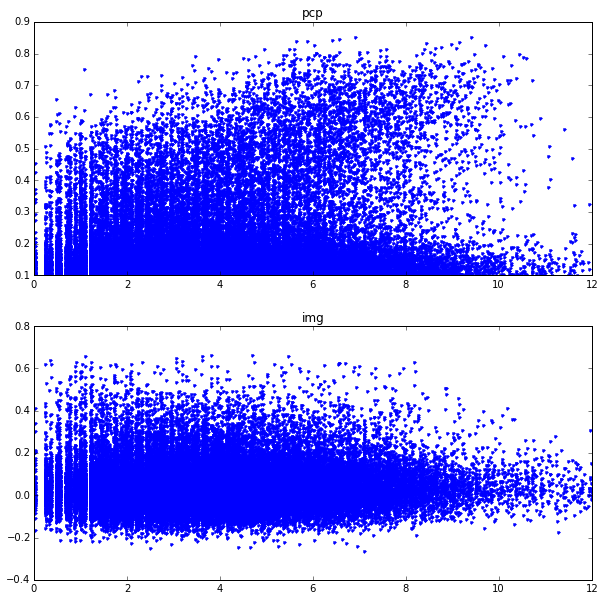

In [58]:
count_thresh = .1
fig = plt.figure(figsize=(10,10))
rfsize = {}
for ii,state in enumerate(state_list):
    n_resamples = len(mst[state].params)
    dx = np.where(map(lambda x: x > count_thresh, val_cc['pcp']))[0]
    xd = np.zeros(len(dx))
    yd = np.zeros(len(dx))
    rfsize[state] = np.zeros(len(dx))
    for n in range(n_resamples):
        
        frf = mst[state].params[n]['frf'][dx]
        xd += mst[state].receptive_fields.rf_table.loc[frf, 'x_deg'].values
        yd += mst[state].receptive_fields.rf_table.loc[frf, 'y_deg'].values
        rfsize[state] += mst[state].receptive_fields.rf_table.loc[frf, 'deg_per_radius'].values
    xd /= n_resamples
    yd /= n_resamples
    rfsize[state] /= n_resamples
    ecc = np.sqrt(xd**2 + yd**2)
#     nums,xedges,yedges = np.histogram2d(ecc,rfsize[state])
    ax=plt.subplot(2,1,ii+1)
    plt.title(state)
#     plt.pcolor(xedges, yedges, nums,cmap='hot')
#     plt.hist(rfsize[state],20,normed=True)
#     plt.xlim([1,10])
#     plt.ylim([0, .6])
    plt.plot(ecc, val_cc[state][dx], '.')
    plt.xlim([0, 12])
    print 'mean ecc: %f' %(np.mean(ecc))
    
# plt.plot(ecc,rfsize['img']/rfsize['pcp'],'.')    
# plt.ylim([0, 9])
# plt.yscale('log')
# plt.xlim([0, 10])

# plt.hist(rfsize['img']/rfsize['pcp'],15, log=True)
# plt.hist(rfsize['pcp']/rfsize['img'],15, log=True,hold=True)
# plt.scatter(rfsize['pcp'], rfsize['img'])
# plt.xlim([0,10])
# plt.ylim([0, 10])
# plt.axes().set_aspect(1)


#### spatial frequency

need to reconstitute gabors because forgot to save them

In [34]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)
n_orientations = 4
deg_per_stimulus = 21.958
lowest_sp_freq = .114 ##cyc/deg
highest_sp_freq = 4.5
num_sp_freq = 8
pix_per_cycle = 4.#2.13333333
complex_cell = True
n_colors = 1 ##let's do grayscale first
diams_per_filter = 4
cycles_per_radius = 2.0

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = diams_per_filter,
                         cycles_per_radius = cycles_per_radius,
                         color_channels=n_colors)
gfm.gbr_table.head(9)

27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees
D = total number of features = 32


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.114000,16,140.350877,10.012848,64,17.543860,0.000000
1,0.192730,16,83.017792,16.927841,64,10.377224,0.000000
2,0.325831,16,49.105171,28.618412,64,6.138146,0.000000
3,0.550854,16,29.045796,48.382631,64,3.630724,0.000000
4,0.931281,16,17.180639,81.796257,64,2.147580,0.000000
5,1.574435,16,10.162379,138.285735,64,1.270297,0.000000
6,2.661758,16,6.011065,233.787525,64,0.751383,0.000000
7,4.500000,16,3.555556,395.244000,64,0.444444,0.000000
8,0.114000,16,140.350877,10.012848,64,17.543860,0.785398


In [35]:
count_thresh = 0.4
feature_tuning = {}
for ii,state in enumerate(state_list):
    n_resamples = len(mst[state].params)
    D = mst[state].D
    dx = np.where(map(lambda x: x > count_thresh, val_cc['img']))[0]
    feature_tuning[state] = np.zeros((D, len(dx)))
    ori_tun = np.zeros((n_orientations, len(dx)))
    for n in range(n_resamples):
        ffw = mst[state].params[n]['ffw'][:,dx]
        feature_tuning[state] += ffw
    feature_tuning[state] /= n_resamples
    

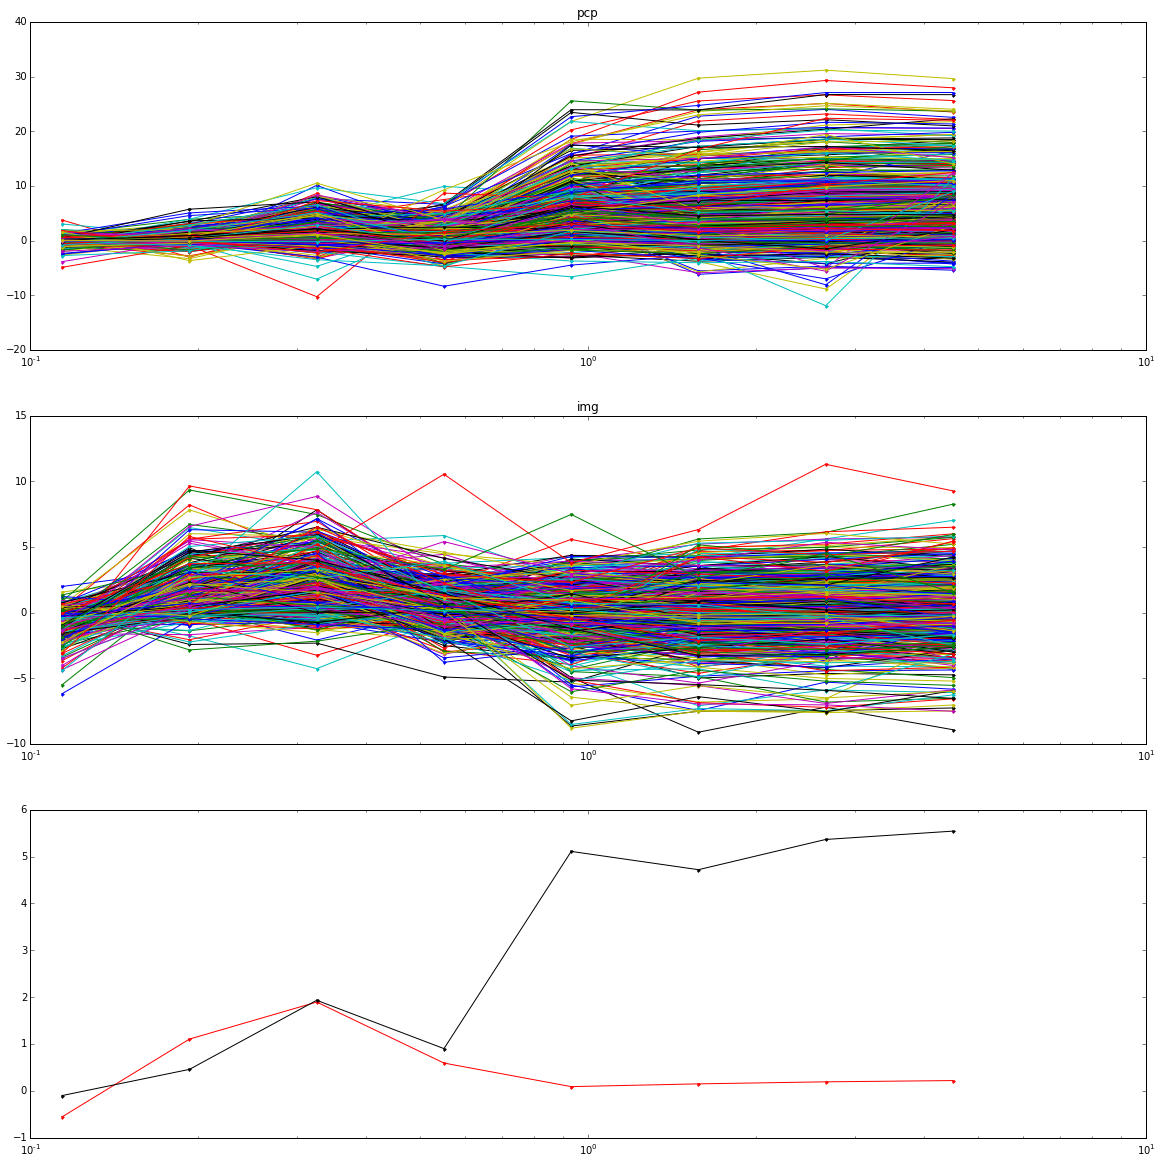

In [36]:
plt.figure(figsize=(20,20))
sp_freq_tun = {}
for ii,state in enumerate(state_list):
    V = feature_tuning[state].shape[1]
    sp_freq_tun[state] = np.zeros((num_sp_freq, V))
    cnt = 0
    freq = []
    for name, grp in gfm.gbr_table.groupby('cycles per deg.'):
        f_index = grp.index
        sp_freq_tun[state][cnt, :] = np.mean(feature_tuning[state][f_index,:],axis=0)
        cnt += 1
        freq.append(name)
    ax=plt.subplot(3,1,ii+1)
    plt.title(state)
    plt.plot(np.array(freq), sp_freq_tun[state], '.-')
    plt.xscale('log')
plt.subplot(3,1,ii+2)
sublist = [0,1,3,4,5,6,7]
plt.plot(np.array(freq), np.mean(sp_freq_tun['img'],axis=1),'.-r')
plt.plot(np.array(freq), np.mean(sp_freq_tun['pcp'],axis=1),'.-k', hold=True)
plt.xscale('log')
#     plt.ylim([0,1.5])

#### orientation

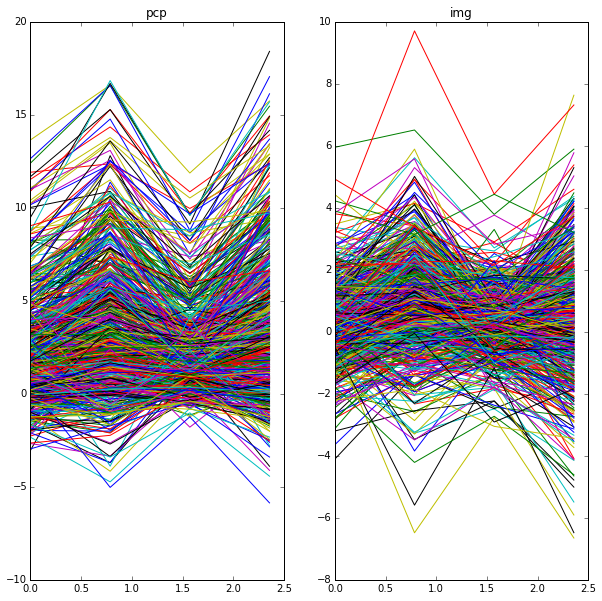

In [37]:
plt.figure(figsize=(10,10))
ori_tun = {}
for ii,state in enumerate(state_list):
    V = feature_tuning[state].shape[1]
    ori_tun[state] = np.zeros((n_orientations, V))
    cnt = 0
    ori = []
    for name, grp in gfm.gbr_table.groupby('orientation'):
        o_index = grp.index
        ori_tun[state][cnt, :] = np.mean(feature_tuning[state][o_index,:],axis=0)
        cnt += 1
        ori.append(name)
    ax=plt.subplot(1,2,ii+1)
    plt.title(state)
    plt.plot(ori, ori_tun[state])
    
#     plt.ylim([0,3.])

#### position img vs position pcp

In [46]:
count_thresh = 0.4
fig = plt.figure(figsize=(10,10))
rfsize = {}
xd = {}
yd = {}
ecc = {}
for ii,state in enumerate(state_list):
    n_resamples = len(mst[state].params)
    dx = np.where(map(lambda x,y: (x > count_thresh) & (y > .25), val_cc['pcp'], val_cc['img']))[0]
    rfsize[state] = np.zeros(len(dx))
    ecc[state] =np.zeros(len(dx)) 
    xd[state] = np.zeros(len(dx))
    yd[state] = np.zeros(len(dx))
    
    for n in range(n_resamples):
        
        frf = mst[state].params[n]['frf'][dx]
        xd[state] += mst[state].receptive_fields.rf_table.loc[frf, 'x_deg'].values
        yd[state] += mst[state].receptive_fields.rf_table.loc[frf, 'y_deg'].values
        rfsize[state] += mst[state].receptive_fields.rf_table.loc[frf, 'deg_per_radius'].values
    xd[state] /= n_resamples
    yd[state] /= n_resamples
    rfsize[state] /= n_resamples
    ecc[state] = np.sqrt(xd[state]**2 + yd[state]**2)

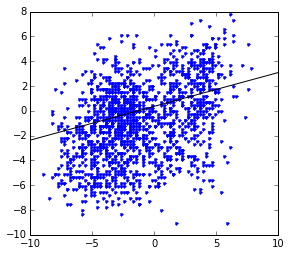

In [47]:
plt.plot(xd['pcp'],xd['img'], '.')

plt.axes().set_aspect(1)
p = np.polyfit(yd['pcp'],yd['img'],1)
yhat = np.polyval(p,np.linspace(-10,10, 100))
plt.plot(np.linspace(-10,10, 100),yhat,'k')

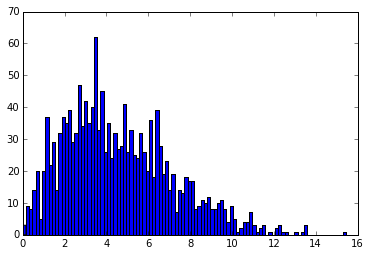

In [48]:
displ = np.sqrt((xd['pcp']-xd['img'])**2+(yd['pcp']-yd['img'])**2)
# c = [np.dot(u,v)/np.norm(u)/np.norm(v) for u,v in zip() # -> cosine of the angle
# angle = arccos(clip(c, -1, 1))
_=plt.hist(displ,100)

In [49]:
from scipy.interpolate import griddata

In [50]:
grid_x,grid_y = np.mgrid[-11:11, -11:11]
foo = griddata((xd['pcp'],yd['pcp']), displ, (grid_x, grid_y), method='linear')

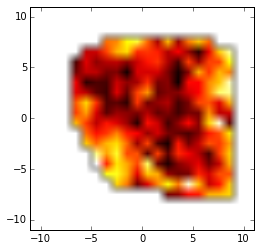

In [51]:
plt.imshow(foo, extent = (-11,11,-11,11),cmap='hot')

(-11, 11)

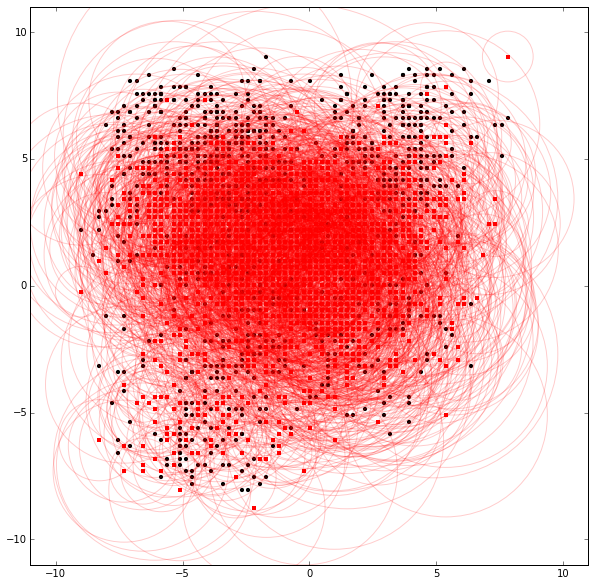

In [52]:
plt.figure(figsize=(10,10))

plt.scatter(xd['pcp'],yd['pcp'],c='k',marker='o',s=10)
for ii,_ in enumerate(xd['img']):
    plt.axes().add_artist(plt.Circle((xd['img'][ii], yd['img'][ii]),radius=rfsize['img'][ii],color='red',fill=False,alpha=.2))
    plt.scatter(xd['img'],yd['img'],c='red',marker='x',s=10,)
plt.axes().set_aspect(1)
plt.xlim([-11, 11])
plt.ylim([-11, 11])

# circle1=plt.Circle((0,0),.2,color='r')
# circle2=plt.Circle((.5,.5),.2,color='b')
# circle3=plt.Circle((1,1),.2,color='g',clip_on=False)
# fig = plt.gcf()
# fig.gca().add_artist(circle1)

(-11, 11)

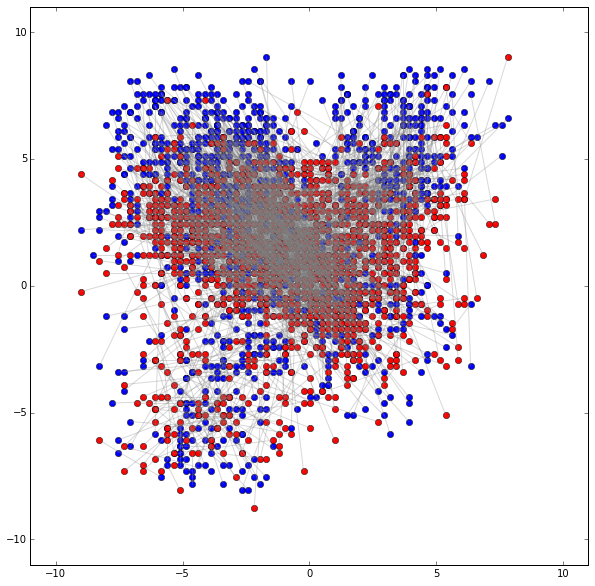

In [53]:
plt.figure(figsize=(10,10))
plt.plot(xd['pcp'],yd['pcp'],'bo')
plt.plot(xd['img'],yd['img'],'ro')
for ii,_ in enumerate(xd['pcp']):
    plt.plot((xd['pcp'][ii],xd['img'][ii]), (yd['pcp'][ii],yd['img'][ii]), 'gray',alpha = .3,hold=True)
plt.axes().set_aspect(1)
plt.xlim([-11, 11])
plt.ylim([-11, 11])

In [ ]:
np.max(displ)